In [2]:
import tensorflow as tf
print("Tensorflow version is:", tf.__version__)

from tensorflow import keras

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.layers import LSTM, Dropout, Dense

import seaborn as sns   # plotting heatmap
from sklearn.model_selection import train_test_split

Tensorflow version is: 2.14.0


In [3]:

y_train_df = pd.read_csv('/Users/jingming/DataSets/COVAREP/y_Train.tsv',sep='\t',header=None)
y_train = y_train_df.iloc[:,1]

y_test_df = pd.read_csv('/Users/jingming/DataSets/COVAREP/y_Test.tsv',sep='\t',header=None)
y_test = y_test_df.iloc[:,1]

In [4]:
X_train_df = []
X_test_df = []
for i in y_train_df.index:
    id = y_train_df[0][i]
    df = pd.read_csv((f'/Users/jingming/DataSets/COVAREP/{id}_COVAREP.csv'),sep=',',header=None)
    X_train_df.append(df)
    
for i in y_test_df.index:
    id = y_test_df[0][i]
    df = pd.read_csv((f'/Users/jingming/DataSets/COVAREP/{id}_COVAREP.csv'),sep=',',header=None)
    X_test_df.append(df)

In [5]:
window_size = 10000

X_train = []
y_train = []

for i in y_train_df.index:
    id = y_train_df[0][i]
    df = X_train_df[i]
    df = df[df[1]==1]
    df = df.drop([ 1],axis=1)
    n = df.to_numpy().shape[0]
    if int(n/window_size) == 0:
        print(i)
    if y_train_df[1][i] == 1:
        for j in range(0,int(n/window_size)):
            # df = np.transpose(df.to_numpy())
            # X_train.append(np.transpose(df[j*window_size:(j+1)*window_size].to_numpy()))
            X_train.append(df[j*window_size:(j+1)*window_size].to_numpy())
            y_train.append(y_train_df[1][i])

    if y_train_df[1][i] == 0:
        pad = int((n-window_size)/2)
        
        X_train.append(df[pad:(pad+window_size)].to_numpy())
        y_train.append(y_train_df[1][i])
    

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
        
X_test = []
y_test = []

for i in y_test_df.index:
    id = y_test_df[0][i]
    # df = pd.read_csv((f'/Users/jingming/DataSets/COVAREP/{id}_COVAREP.csv'),sep=',',header=None)
    df = X_test_df[i]
    df = df[df[1]==1]
    df = df.drop([ 1],axis=1)
    n = df.to_numpy().shape[0]

    if y_test_df[1][i] == 1:
        for j in range(0,int(n/window_size)):
            # df = np.transpose(df.to_numpy())
            # X_test.append(np.transpose(df[j*window_size:(j+1)*window_size].to_numpy()))
            X_test.append(df[j*window_size:(j+1)*window_size].to_numpy())
            y_test.append(y_test_df[1][i])

    if y_test_df[1][i] == 0:
        pad = int((n-window_size)/2)
        
        X_test.append(df[pad:(pad+window_size)].to_numpy())
        y_test.append(y_test_df[1][i])
    
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [6]:
X = np.concatenate((X_train , X_test))
y = np.concatenate((y_train , y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

window_size == 10000
layers=[8, 8, 8, 1], train_examples=180, test_examples=61
batch = 180, timesteps = 10000, features = 73, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10000, 8)          2624      
                                                                 
 batch_normalization (Batch  (None, 10000, 8)          32        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 10000, 8)          544       
                                                                 
 batch_normalization_1 (Bat  (None, 10000, 8)          32        
 chNormalization)                                                
                                                      

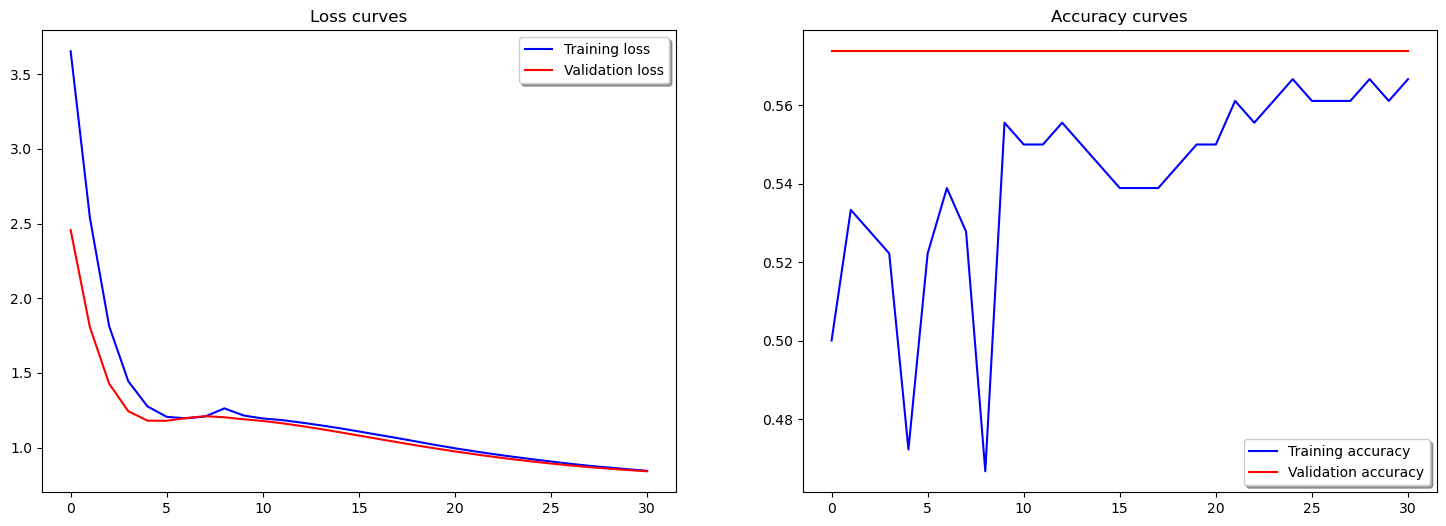

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from time import time

print(f'window_size == {window_size}')

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
T = window_size
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')


# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
History.history.keys()

In [13]:
from sklearn.metrics import classification_report,f1_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test, batch_size=BATCH, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(f'f1_score = ',f1_score(y_test, y_pred_bool))

print(classification_report(y_test, y_pred_bool))

confusion_matrix(y_test,y_pred_bool)


1/1 [==============================] - 1s 901ms/step
f1_score =  0.0
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        26
           1       0.00      0.00      0.00        35

    accuracy                           0.43        61
   macro avg       0.21      0.50      0.30        61
weighted avg       0.18      0.43      0.25        61



/Users/jingming/miniforge3/envs/voice-biomarker-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jingming/miniforge3/envs/voice-biomarker-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jingming/miniforge3/envs/voice-biomarker-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

array([[26,  0],
       [35,  0]])

In [ ]:
y_test

In [12]:
y_pred_bool

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(f'count of y_train == 0: {np.count_nonzero(y_train == 0)} \ncount of y_test == 0: {np.count_nonzero(y_test == 0)} \ncount of y_train == 1: {np.count_nonzero(y_train == 1)} \ncount of y_test == 0: {np.count_nonzero(y_test == 1)}',)

In [8]:
from keras_visualizer import visualizer
visualizer(model, file_format='png', view=True)